In [138]:
import numpy as np
import pandas as pd
from sklearn import metrics
from math import sqrt
import matplotlib.pyplot as plt
import lightgbm as lgb
import sklearn.preprocessing as pre
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn import ensemble
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

pd.set_option('display.max_columns', 100)

In [139]:
train = pd.read_csv("/Users/milesklingenberg/Documents/UWMSBA/590/Data/cleaned_data_train.csv")
test = pd.read_csv("/Users/milesklingenberg/Documents/UWMSBA/590/Data/cleaned_data_test.csv")

In [140]:
to_drop = ['BsmtFinSF2', 'BsmtHalfBath', 'MiscVal', 'Utilities', 
            'MoSold', 'YrSold']

train.drop(to_drop, axis=1, inplace=True)
test.drop(to_drop, axis=1, inplace=True)

In [141]:
X = train.drop(['SalePrice'], axis=1)
Y = train.loc[:, 'SalePrice']

In [142]:
from sklearn import metrics, tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from xgboost import XGBRegressor

In [143]:
XGB = XGBRegressor(n_jobs=-1)

In [144]:
# Use a grid over parameters of interest
param_grid = {
     'colsample_bytree':[0.3, 0.8, 1.0],
     'n_estimators':[40 ,80, 150, 200,240, 300],
     'max_depth': [1,2, 3,5, 8]
}

In [145]:
CV_XGB = GridSearchCV(estimator=XGB, param_grid=param_grid, cv= 10)

In [146]:
%time CV_XGB.fit(X, Y)

CPU times: user 5min 42s, sys: 394 ms, total: 5min 43s
Wall time: 5min 43s


GridSearchCV(cv=10, error_score=nan,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estim...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=Non

In [147]:
best_xgb_model = CV_XGB.best_estimator_
print(CV_XGB.best_score_, CV_XGB.best_params_)

0.8998214727383456 {'colsample_bytree': 1.0, 'max_depth': 3, 'n_estimators': 240}


In [148]:
pred_train_xgb = best_xgb_model.predict(X)
pred_test_xgb = best_xgb_model.predict(test)

In [149]:
print(metrics.mean_squared_log_error(Y, pred_train_xgb).round(5))
print(sqrt(mean_squared_error(Y, pred_train_xgb)))

0.00143
5445.534259404698


In [150]:
y_train = pd.DataFrame(Y)
pred_train_xgb = pd.DataFrame(pred_train_xgb)
error_df = [Y, pred_train_xgb]
error_df = pd.concat(error_df, axis=1)
error_df.columns = ['SalePrice', 'Prediction_train']
error_df['error'] = error_df['SalePrice']-error_df['Prediction_train']

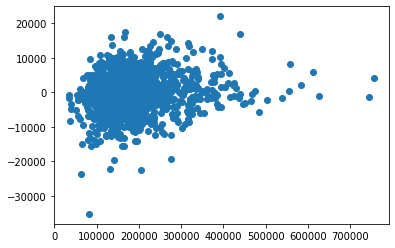

In [151]:
plt.scatter(error_df['SalePrice'], error_df['error'])
plt.show()

In [152]:
y_pred_test_xgb = pd.DataFrame(pred_test_xgb, columns = ['SalePrice'])

In [153]:
y_pred_test_xgb['Id'] = test['Id']

In [154]:
columnsTitles = ['Id', 'SalePrice']
submission = y_pred_test_xgb.reindex(columns=columnsTitles)
submission .head()

,Id,SalePrice
0,1461,142197.921875
1,1462,182401.921875
2,1463,190409.125000
3,1464,186248.562500
4,1465,178439.609375


In [155]:
submission.to_csv(r'/Users/milesklingenberg/Documents/UWMSBA/590/Data/submission.csv', index=False)

In [176]:
lgbm = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)



In [177]:
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [ 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]

climber = RidgeCV(alphas=alphas_alt)

In [178]:
scaler1 = pre.RobustScaler()
scaler2 = pre.FunctionTransformer(np.log1p, np.expm1)

In [181]:
models = [('xgb', best_xgb_model),
        ('lgb', make_pipeline(scaler1, TransformedTargetRegressor(lgbm,scaler2)))]

In [182]:
stack = ensemble.StackingRegressor(estimators=models)

stack = stack.fit(X,Y)

In [183]:
preds = pd.DataFrame(stack.predict(test))

In [184]:
pred_train = stack.predict(X)
print(sqrt(mean_squared_error(Y, pred_train)))
print(metrics.mean_squared_log_error(Y, pred_train).round(5))

7627.708799033309
0.00221


In [185]:
all_pred = []
for model in models:
    model[1].fit(X, Y)
    pred = model[1].predict(test)
    all_pred.append(pred)
    

all_pred = np.array(all_pred)
all_pred

array([[142197.921875  , 182401.921875  , 190409.125     , ...,
        171445.4375    , 118625.6015625 , 228760.46875   ],
       [138274.76324772, 178363.61332829, 190609.83704335, ...,
        185474.49613083, 143416.00896848, 235881.24112132]])

In [186]:
ave_df = pd.DataFrame(all_pred.T, columns=['xgb', 'lgb'])

In [187]:
ave_df['actual'] = train['SalePrice']

In [188]:
ave_df

,xgb,lgb,actual
0,142197.921875,138274.763248,208500
1,182401.921875,178363.613328,181500
2,190409.125000,190609.837043,223500
3,186248.562500,188294.010187,140000
4,178439.609375,189303.932618,250000
...,...,...,...
1454,109203.859375,102939.611334,185000
1455,95880.281250,98140.371446,175000
1456,171445.437500,185474.496131,210000
1457,118625.601562,143416.008968,266500


In [192]:
ave_df['ave'] = ave_df.iloc[:, 0:2].apply(np.mean, axis=1)
ave_df

,xgb,lgb,actual,ave
0,142197.921875,138274.763248,208500,140236.342561
1,182401.921875,178363.613328,181500,180382.767602
2,190409.125000,190609.837043,223500,190509.481022
3,186248.562500,188294.010187,140000,187271.286343
4,178439.609375,189303.932618,250000,183871.770997
...,...,...,...,...
1454,109203.859375,102939.611334,185000,106071.735354
1455,95880.281250,98140.371446,175000,97010.326348
1456,171445.437500,185474.496131,210000,178459.966815
1457,118625.601562,143416.008968,266500,131020.805265


In [224]:
submission3 = pd.DataFrame({'Id':test['Id'], 'SalePrice': ave_df.ave})
submission.to_csv(r'/Users/milesklingenberg/Documents/UWMSBA/590/Data/submission3.csv', index=False)

In [225]:
submission3

,Id,SalePrice
0,1461,140236.342561
1,1462,180382.767602
2,1463,190509.481022
3,1464,187271.286343
4,1465,183871.770997
...,...,...
1454,2915,106071.735354
1455,2916,97010.326348
1456,2917,178459.966815
1457,2918,131020.805265
